# CNN sur classification manuelle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# code pour préparer X et y

In [ ]:
df = pd.read_csv("dataset_500Hz.csv")
df.head()

,hpc_500,pfc_500,manual_500
0,62.844705,51.656355,0
1,137.740828,57.758723,0
2,80.019974,23.671246,0
3,89.810803,39.607111,0
4,58.157103,64.048580,0


## Netooyage et paramètres

In [ ]:
FS = 500  # Fréquence d'échantillonnage
WINDOW_SIZE = FS * 1  # 1 seconde = 500 points

# On s'assure que le nombre total de points est un multiple de 500
# pour éviter les erreurs lors du redimensionnement (reshape)
num_samples = len(df) // WINDOW_SIZE
limit = num_samples * WINDOW_SIZE

# On coupe le dataframe pour qu'il tombe pile poil
df_clean = df.iloc[:limit]

## 3. Création des Inputs (X) - Reshape en 3D

In [ ]:
# Format voulu : (Nombre_de_secondes, 500, 2)
# Colonnes : hpc_500, pfc_500
X_flat = df_clean[['hpc_500', 'pfc_500']].values
X = X_flat.reshape(num_samples, WINDOW_SIZE, 2)

## 4. Création des Labels (y)

In [ ]:
# Tes labels sont répétés 500 fois par seconde. On ne prend que le 1er de chaque bloc.
y_raw = df_clean['manual_500'].values[::WINDOW_SIZE]

# 5. Encodage des labels (Gestion du 0, 1, 3, 4, 5)

In [ ]:
# Le réseau a besoin de 0, 1, 2, 3, 4 strict.
le = LabelEncoder()
y = le.fit_transform(y_raw)
CLASSES_ORIGINALES = le.classes_ # Pour se souvenir que 2 = "3" par exemple
NUM_CLASSES = len(CLASSES_ORIGINALES)

print(f"Format des données X : {X.shape}") # Devrait être (N, 500, 2)
print(f"Format des labels y : {y.shape}")  # Devrait être (N,)
print(f"Labels détectés : {CLASSES_ORIGINALES}")

Format des données X : (2743, 500, 2)
Format des labels y : (2743,)
Labels détectés : [0 1 3 4 5]


# 6. Split Train / Test (80% entrainement, 20% validation)

In [ ]:
# 'stratify=y' assure qu'on a la même proportion de sommeil/éveil dans les deux sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Chemin de sauvegarde

In [ ]:
# Le fichier .keras est le format moderne recommandé par TensorFlow
checkpoint_path = "meilleur_cnn_cerveau.keras"

In [ ]:
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1 # Affiche un message quand il sauvegarde
)

# modèle

In [ ]:
def build_brain_cnn(input_shape, num_classes):
    model = models.Sequential()

    # Bloc 1
    model.add(layers.Conv1D(16, 10, activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    # Bloc 2
    model.add(layers.Conv1D(32, 5, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    # Bloc 3
    model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(2))

    # Classification
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = build_brain_cnn((WINDOW_SIZE, 2), NUM_CLASSES)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement
# Batch_size = 32 : Le réseau regarde 32 secondes de signal avant de se mettre à jour
# 4. On relance l'entraînement avec les callbacks
print("Lancement de l'entraînement...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_cb]
)

Lancement de l'entraînement...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6251 - loss: 1.1134
Epoch 1: val_accuracy improved from -inf to 0.79964, saving model to meilleur_cnn_cerveau.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6264 - loss: 1.1090 - val_accuracy: 0.7996 - val_loss: 0.6045
Epoch 2/20
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7939 - loss: 0.5799
Epoch 2: val_accuracy did not improve from 0.79964
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7939 - loss: 0.5795 - val_accuracy: 0.7341 - val_loss: 0.6580
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8015 - loss: 0.5237
Epoch 3: val_accuracy improved from 0.79964 to 0.82332, saving model to meilleur_cnn_cerveau.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8018 - loss: 0.5232 - val_accuracy: 0.8233 - val_loss: 0.4721
Epoch 4/20
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8169 - loss: 0.4689
Epoch 4: val_accuracy improved from 0.82332 to 0.83424, saving model to meill

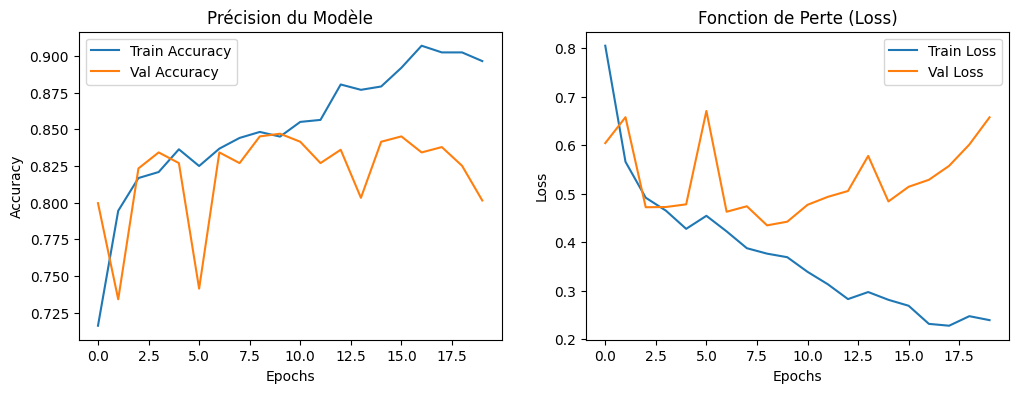

In [ ]:
# --- VISUALISATION ---

plt.figure(figsize=(12, 4))

# Courbe de Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Précision du Modèle')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de Perte (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Fonction de Perte (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# visualisation

Chargement du meilleur modèle sauvegardé...
Calcul des prédictions sur le jeu de test...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


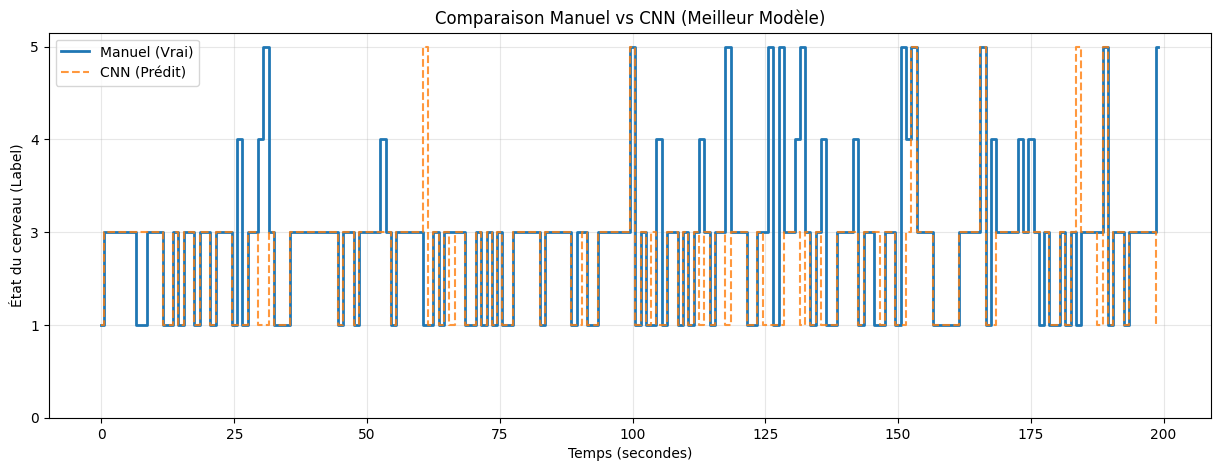


--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.73      0.83      0.78       147
           3       0.91      0.96      0.94       345
           4       0.00      0.00      0.00        28
           5       0.65      0.38      0.48        29

    accuracy                           0.85       549
   macro avg       0.46      0.43      0.44       549
weighted avg       0.80      0.85      0.82       549



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

In [ ]:
# 1. On charge le MEILLEUR modèle sauvegardé par le checkpoint
# (Sinon on utilise le modèle de l'époque 20 qui est peut-être moins bon)
print("Chargement du meilleur modèle sauvegardé...")
best_model = tf.keras.models.load_model("meilleur_cnn_cerveau.keras")

# 2. On calcule les prédictions (C'est la ligne qui manquait !)
print("Calcul des prédictions sur le jeu de test...")
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) # On prend l'index de la proba max

# 3. Affichage de l'Hypnogramme comparatif
limit_plot = 200
y_test_sample = y_test[:limit_plot]
y_pred_sample = y_pred[:limit_plot]

time_axis = np.arange(limit_plot)

plt.figure(figsize=(15, 5))

# On décale légèrement les courbes pour qu'elles ne se superposent pas totalement
plt.step(time_axis, y_test_sample, where='mid', label='Manuel (Vrai)', linewidth=2)
plt.step(time_axis, y_pred_sample, where='mid', label='CNN (Prédit)', linestyle='--', alpha=0.8)

# Remettre les vrais labels sur l'axe Y
plt.yticks(range(NUM_CLASSES), CLASSES_ORIGINALES)
plt.xlabel('Temps (secondes)')
plt.ylabel('État du cerveau (Label)')
plt.title('Comparaison Manuel vs CNN (Meilleur Modèle)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Petit rapport textuel pour confirmer la performance
print("\n--- RAPPORT DE CLASSIFICATION ---")
# On génère la liste des indices attendus : [0, 1, 2, 3, 4]
labels_indices = np.arange(len(CLASSES_ORIGINALES))

print(classification_report(y_test, y_pred,
                            labels=labels_indices, # On force l'affichage des 5 classes
                            target_names=[str(c) for c in CLASSES_ORIGINALES]))